## Imports

In [ ]:
from typing import Callable

import torch
import numpy as np
import plotly.io as pio
import plotly.express as px
from torch.optim import AdamW
from rich.progress import track
from pandas import DataFrame as DF
from torch.utils import data as torch_data
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader as DL
from torch.optim.lr_scheduler import ExponentialLR, LRScheduler, OneCycleLR

from models import mk_model
from datasets import TrainValidationPreprocessedOpenFWI as OpenFWIDataset

# Make the plotly plots (mostly) renderable on github.
pio.renderers.default = "jupyterlab+png"

## Datasets and data loaders

In [3]:
train_dataset = OpenFWIDataset("train")
train_loader = torch_data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = OpenFWIDataset("validation")
test_loader = torch_data.DataLoader(train_dataset, batch_size=512, shuffle=True)

Output()

Output()

Output()

Output()

## Training

### Definitions

In [ ]:
def fit(epochs:int,
        model: torch.nn.Module,
        scheduler: LRScheduler,
        optimizer: torch.optim.Optimizer,
        train_loader: DL,
        evaluation_func: callable=None,
    ) -> DF:
    scaler = GradScaler(device="cuda")
    metrics: list[dict] = []
    for epoch in range(epochs):
        total_epoch_loss = 0
        nb_samples = 0
        progress = track(train_loader, description=f"epoch {epoch}")
        step = 0
        for x, y in progress:
            # forward
            x = x.cuda()
            y = y.cuda()
            nb_samples += len(x)
            model.train()
            optimizer.zero_grad()
            with autocast(device_type="cuda"):
                y_pred = model(x)
            loss_value = (y_pred - y).abs().mean()
            
            if loss_value.item() is None:
                print("Warning: Got NaN loss, something went wring.")
                return DF.from_records(metrics) 
            # backward
            scaler.scale(loss_value).backward()
            # scaler.unscale_(optimizer)
            # optional grad clipping ?
            scaler.step(optimizer)
            scaler.update()
            if step:
                scheduler.step()
            # metrics
            # print(loss_value.item())
            total_epoch_loss += loss_value.item()
            metrics.append({
                "step": step,
                "epoch": epoch,
                "batch_train_loss": loss_value.item(),
                **optimizer.state_dict()["param_groups"][-1],
            })
            # progress.set_descriptionset_description(f"epoch: {epoch}, batch_loss: {loss_value.item():.4f}")
            step += 1

        metrics[-1]["train_epoch_loss"] = total_epoch_loss / len(train_loader)
        print(metrics[-1]["train_epoch_loss"])
        if evaluation_func:
            eval_metrics = evaluation_func()
            print("evaluation:", eval_metrics)
            metrics[-1].update(eval_metrics)
        
    return DF.from_records(metrics)

### Find lr

#### Run mock training

In [ ]:
MOCK_TRAINING_EPOCHS = 3
STARTING_LR = 1e-5

mock_model = mk_model()
mock_optim = AdamW(mock_model.parameters(), lr=STARTING_LR)
mock_training_metrics = fit(
    epochs=MOCK_TRAINING_EPOCHS,
    model=mock_model,
    optimizer=mock_optim,
    scheduler=ExponentialLR(mock_optim, 1.01),
    train_loader=train_loader,
)
mock_training_metrics = (
    mock_training_metrics
    .query("batch_train_loss.notna()")
    .set_index("lr")
)

Output()

#### Visualize smoothed loss over learning rate

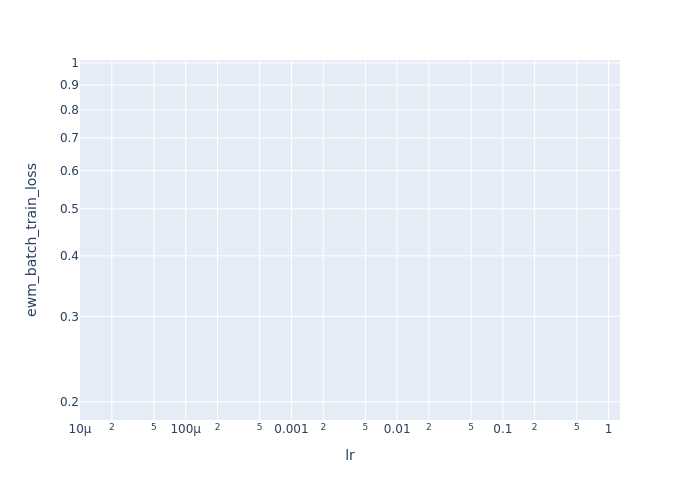

In [ ]:
mock_training_metrics["ewm_batch_train_loss"] = (
    mock_training_metrics
    .ewm(com=15, ignore_na=False)
    ["batch_train_loss"]
    .mean()
)

px.line(
    mock_training_metrics,
    y="ewm_batch_train_loss",
    log_x=True,
    log_y=True
)

### Fit model

In [ ]:
def evaluate_model(model: torch.nn.Module, critirion=torch.nn.L1Loss()) -> dict:
    
    model = model.eval()
    
    total_test_loss = 0
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()
        with autocast("cuda"):
            y_pred = model(x)
        total_test_loss += critirion(y_pred, y)
    total_test_loss /= len(test_loader)
        
    return {"test_loss": total_test_loss}

evaluate_model(mk_model())

{'test_loss': 0.9767795138888888}

In [ ]:
max_lr = mock_training_metrics["ewm_batch_train_loss"].idxmin() * 2
max_lr


TRAINING_EPOCHS = 4
STEPS_PER_EPOCH = len(mock_training_metrics.query("epoch == 0"))


model = mk_model()
optimizer = AdamW(model.parameters(), lr=max_lr)
scheduler = OneCycleLR(
    optimizer,
    max_lr,
    epochs=TRAINING_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)
training_metrics = fit(
    TRAINING_EPOCHS,
    model,
    scheduler,
    optimizer,
    train_loader,
    lambda :evaluate_model(model)
)

Output()

0.29525903629351263
evaluation:


Output()

0.17965906843354432
evaluation:


Output()

0.14410029544106012
evaluation:


Output()

0.1137899278085443
evaluation:


#### Visualize loss over training steps

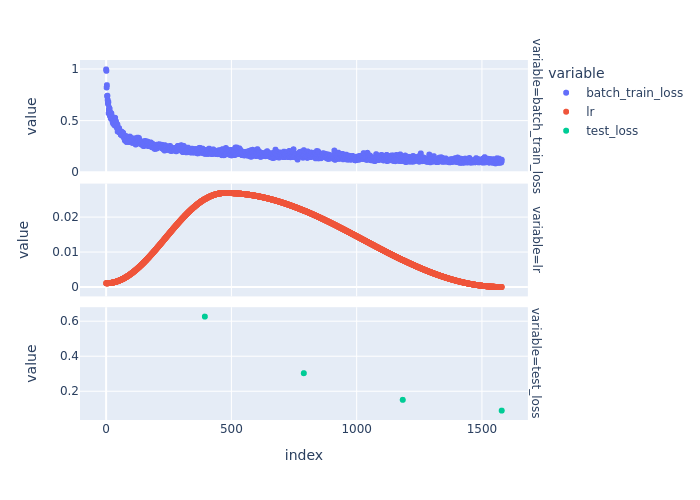

In [ ]:
px.scatter(
    (
        training_metrics
        .reset_index()
        .melt(
            id_vars="index",
            value_vars=["batch_train_loss", "lr", "test_loss"],
        )
    ),
    x="index",
    y="value",
    color="variable",
    facet_row="variable",
    render_mode='lines+markers',
).update_yaxes(matches=None)

#### Save model

In [ ]:
! mkdir -p "models"
torch.save(model.state_dict(), "./models/latest_model.pth")

## Visualize trained model's outputs

train


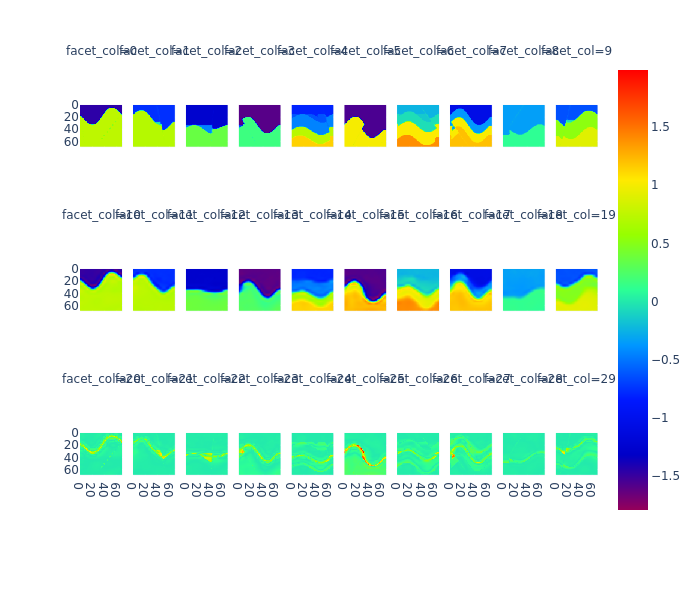

test


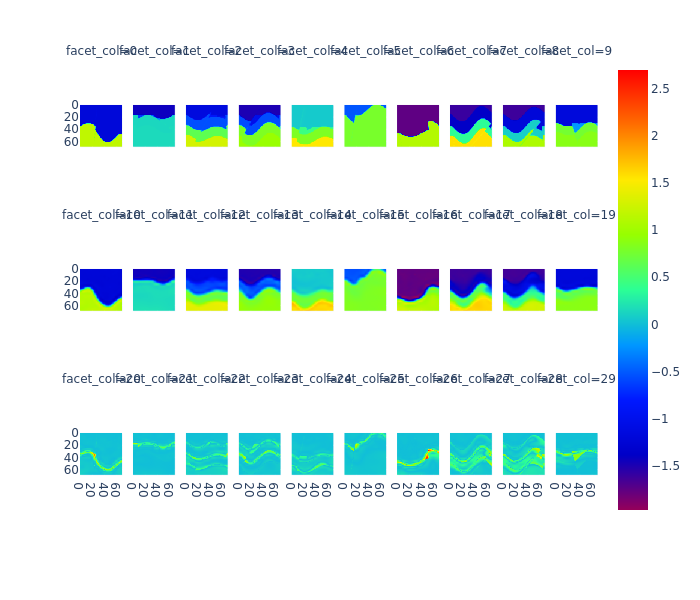

In [ ]:
OFFSET = 50
IMGS_TO_SHOW = 10

def viz_model_outputs(data_loader: DL):
    x, y = next(iter(data_loader))


    y_true_to_display = (
        y
        .cpu()
        .numpy()
        [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
    )
    with autocast("cuda"):
        y_pred = model(x.cuda())
    y_pred_to_display = (
        y_pred
        .cpu()
        .detach()
        .numpy()
        [OFFSET:OFFSET+IMGS_TO_SHOW, 0, ...]
    )

    px.imshow(
        np.concatenate((
            y_true_to_display,
            y_pred_to_display,
            np.abs(y_pred_to_display - y_true_to_display), # Absolute loss
        )),
        facet_col=0,
        facet_col_wrap=IMGS_TO_SHOW,
        color_continuous_scale="Rainbow",
        height=600,
    ).show()

print('train')
viz_model_outputs(train_loader)
print('test')
viz_model_outputs(test_loader)